In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cv2

#from sklearn.metrics import accuracy_score, confusion_matrix

In [3]:
IMG_PATH = Path('/gws/nopw/j04/iecdt/computer-vision-data')
LABELS_PATH = Path('/gws/nopw/j04/iecdt/JERMIT_the_frog/')

In [4]:
labels = pd.read_csv(LABELS_PATH / 'hydrometeors_time_aligned_classes.csv', index_col=0)
dset_size = labels.shape[1]

In [26]:
def preprocess_img(img):
    img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def get_imgs(fname):
    img_a = cv2.imread(IMG_PATH / f'cam_a/compressed_rectified_imgs/{fname}.png')
    img_b = cv2.imread(IMG_PATH / f'cam_b/compressed_rectified_imgs/{fname}.png')
    return preprocess_img(img_a), preprocess_img(img_b)

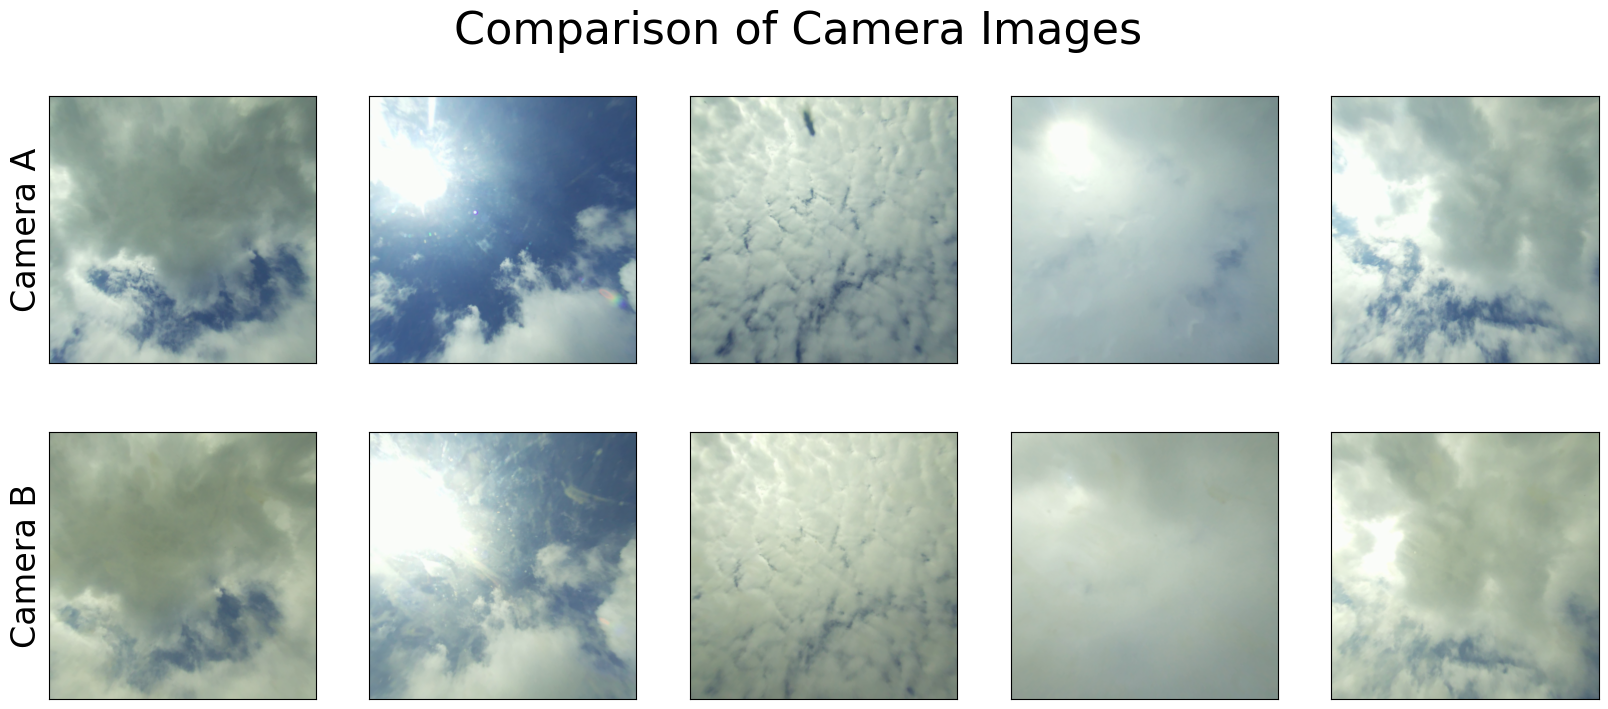

In [32]:
#Plot some matched examples from the rectified images with camera A on top and camera B on the bottom
fig, ax = plt.subplots(2, 5, figsize=(20, 8))
for axs in ax.flatten():
    axs.set_xticks([])
    axs.set_yticks([])
for i in range(5):
    n = np.random.randint(0,13760)
    img_A, img_B = get_imgs(labels.columns[n])
    ax[0,i].imshow(img_A)
    ax[1,i].imshow(img_B)
    img_A = preprocess_img(img_A)
    img_B = preprocess_img(img_B)

fig.suptitle("Comparison of Camera Images", fontsize=32)

row_titles = ["Camera A", "Camera B"]
for i, row in enumerate(ax):
    row[0].set_ylabel(row_titles[i], fontsize=24)

In [28]:
# Camera parameters (from calibration)
img_px_width = 3040
fov = 90
focal_length = img_px_width / (2 * np.tan(np.deg2rad(fov / 2)))  # Adjust based on your camera calibration
baseline = 271  # Distance between the cameras in meters

In [29]:
# StereoSGBM parameters
num_disparities = 16*4
blocksize = 5

In [30]:
sel_imgs = np.random.randint(0, 13760, size=5)
height_bins = np.insert(labels.index.values, 0, 0)

In [ ]:
np.array

In [66]:
for i, n in enumerate(np.array([2000,6000,8000])):
    print(i,n)



0 2000
1 6000
2 8000


In [62]:
np.arange(2000,12000, 2000)

array([ 2000,  4000,  6000,  8000, 10000])

/tmp/ipykernel_312527/4217723656.py:48: RuntimeWarning: invalid value encountered in cast
  depth_vis = np.uint8(depth_vis)


12396.0 13844.039
5261.0 13844.039
10891.0 13844.039
7617.0 13844.039
10231.0 13844.039


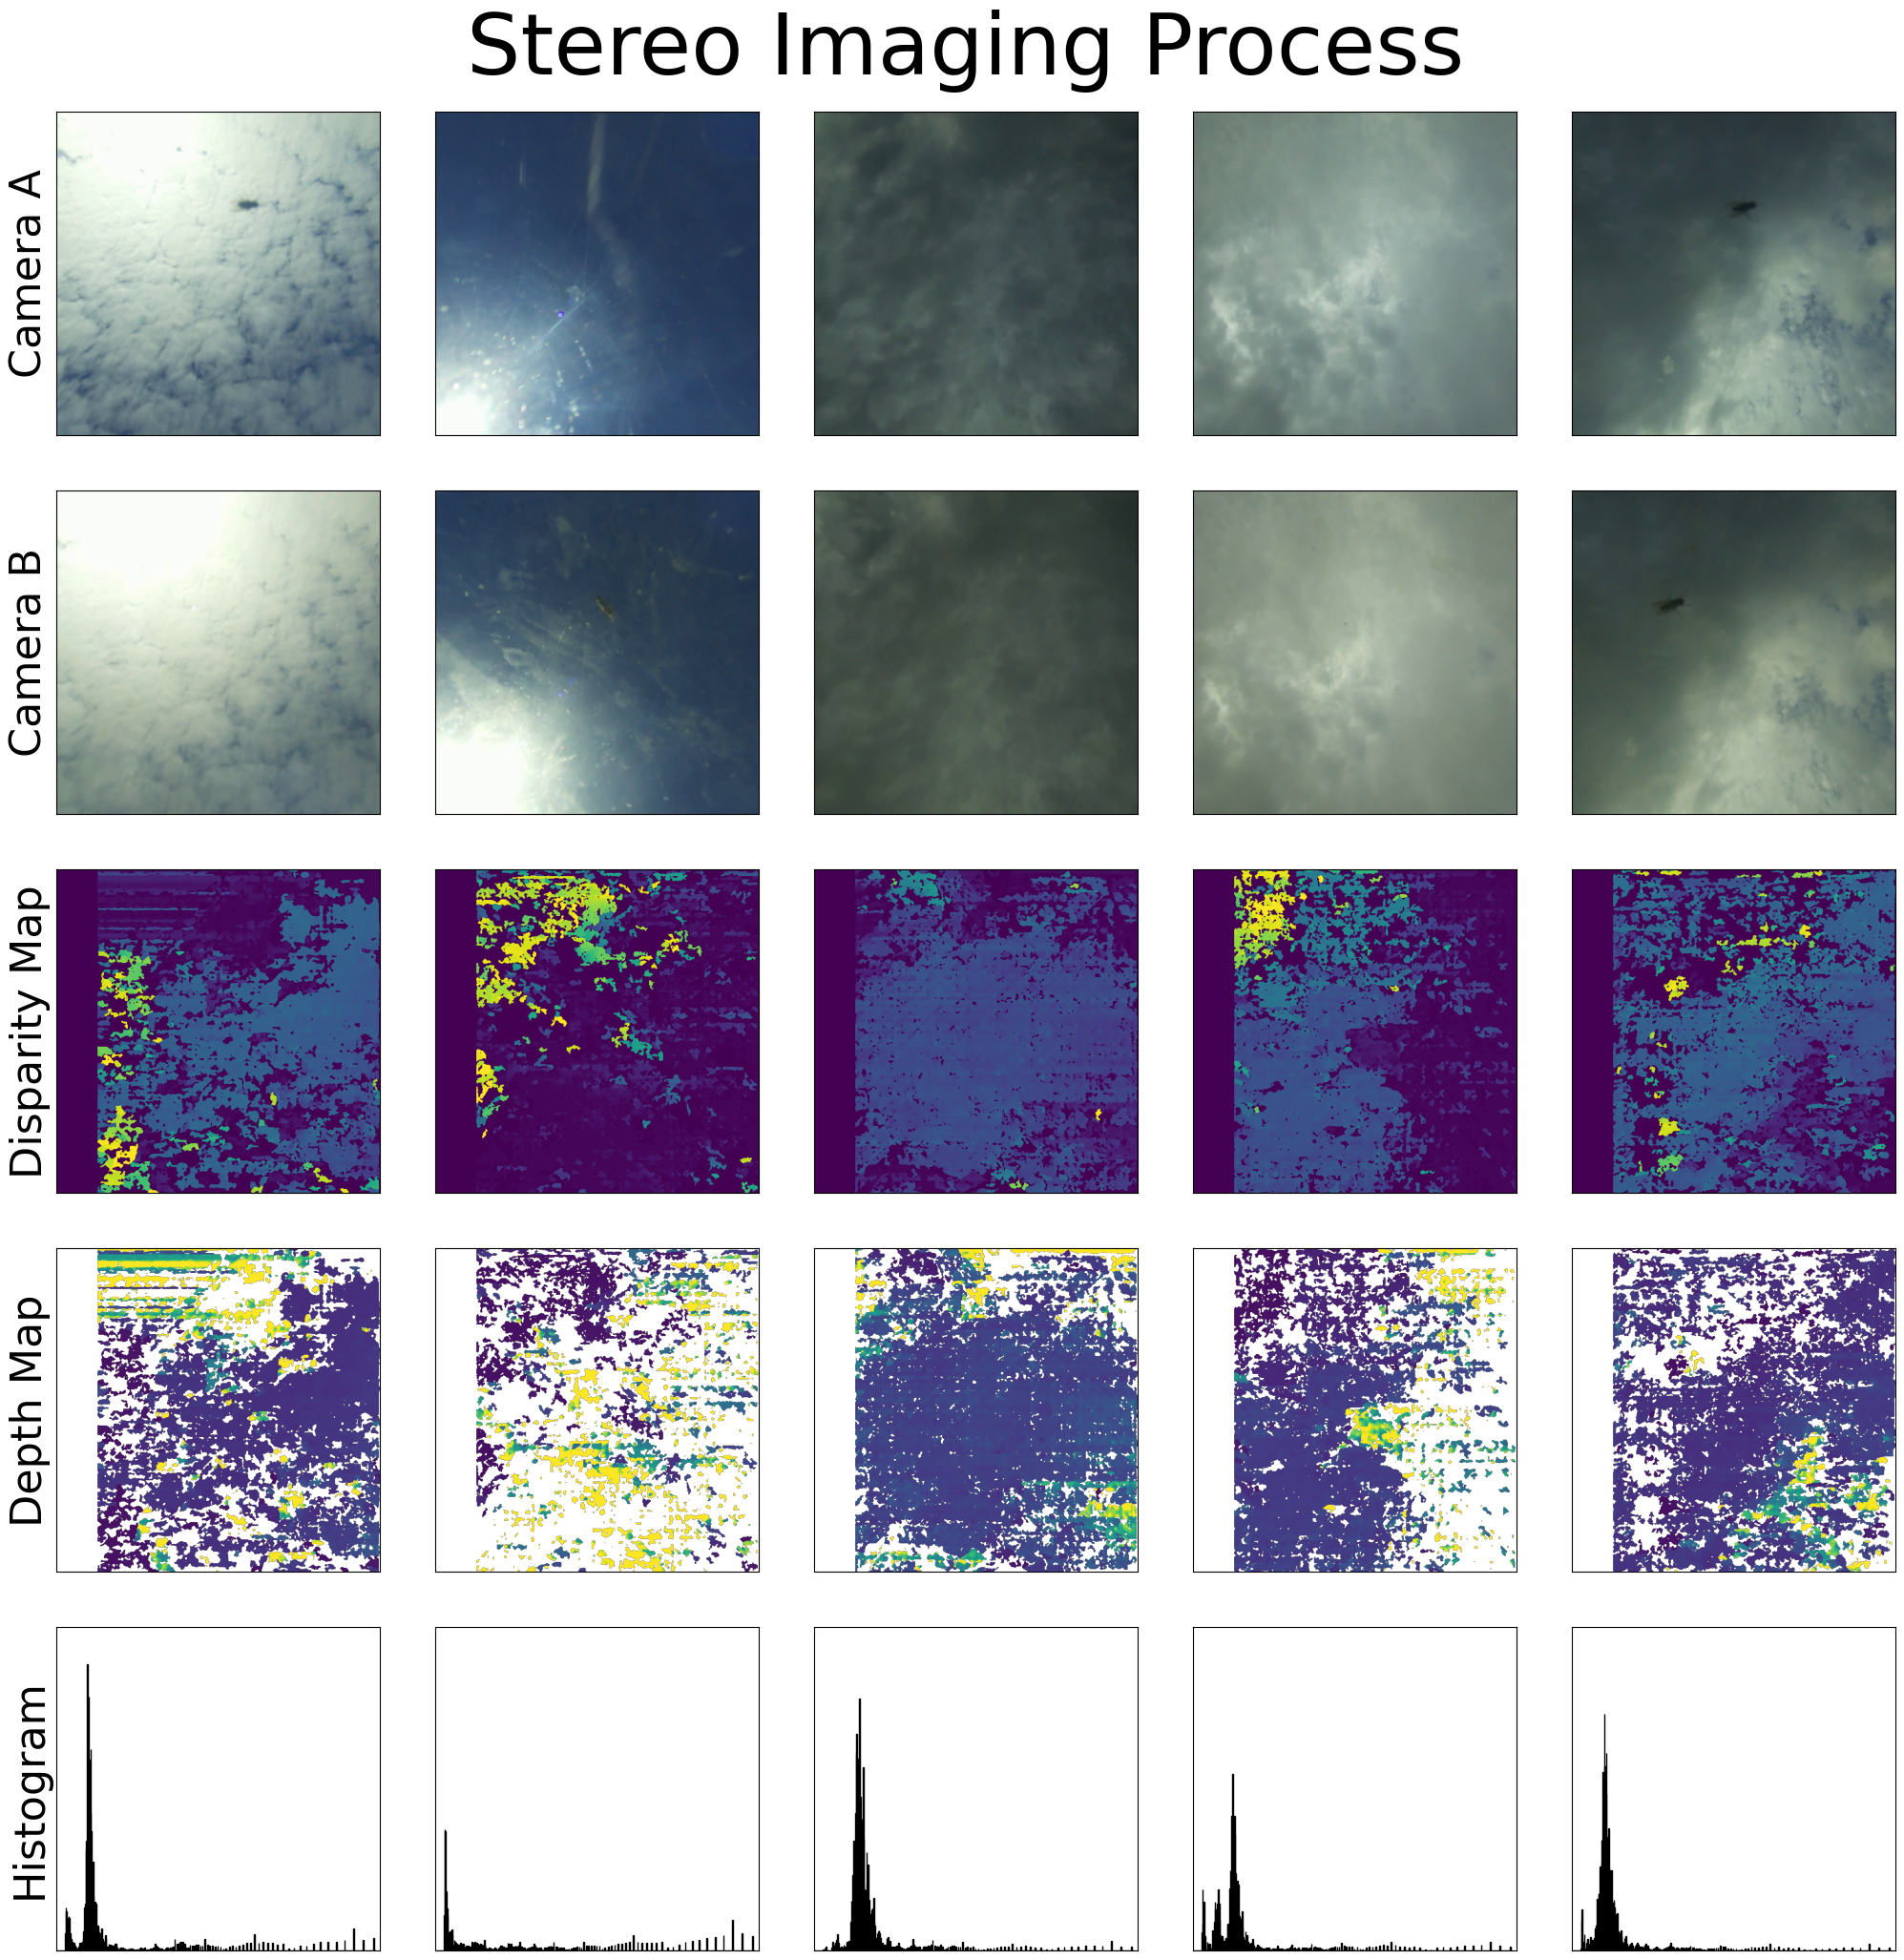

In [69]:
fig, ax = plt.subplots(5, 5, figsize=(20, 20))
plt.tight_layout() 

for axs in ax.flatten():
    axs.set_xticks([])
    axs.set_yticks([])

for i, n in enumerate(np.array([10500,10750,11000,11250,11500])):
    # Load stereo images (left and right)
    img_A, img_B = get_imgs(labels.columns[n])

    # Plot original rectified images
    ax[0,i].imshow(img_A)
    ax[1,i].imshow(img_B)

    # Create SGM matcher
    sgm = cv2.StereoSGBM_create(
        minDisparity=0,
        numDisparities=num_disparities,  # Should be a multiple of 16
        blockSize=blocksize,
        P1=8 * 3 * blocksize**2,  # 8 * number_of_channels * blockSize^2
        P2=32 * 3 * blocksize**2,
        disp12MaxDiff=7,
        uniquenessRatio=7,
        speckleWindowSize=50,
        speckleRange=3
    )

    # Compute disparity map
    disparity = sgm.compute(img_A, img_B)

    # Normalize and display
    disparity_norm = cv2.normalize(disparity, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    disparity_vis = np.uint8(disparity_norm)

    ax[2,i].imshow(disparity_vis)

    # Disparity is set to float
    disparity = disparity.astype(np.float32)

    # Avoid division by zero
    disparity[disparity <= 0] = np.nan  # Prevent infinite depth

    depth_map = (focal_length * baseline) / disparity

    # Display depth map
    depth_vis = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX)
    depth_vis = np.uint8(depth_vis)

    depth_norm = mcolors.Normalize(vmin=0, vmax=10000)
    ax[3,i].imshow(depth_map, cmap=plt.cm.viridis, norm=depth_norm)
    
    #ax[4,i].hist(depth_map.flatten(), bins=height_bins)

    counts, bins, _ = ax[4,i].hist(depth_map.flatten(), bins=height_bins, edgecolor='black')
    ax[4,i].set_xlim(0, 14000)
    ax[4,i].set_ylim(0, 14000)  # Use max count as y limit
    #ax[4,i].set_aspect(14000 / 2534.0)  # Adjust aspect ratio manually
    print(max(counts), max(bins))

    ax[4,i].set_aspect("equal")

row_titles = ["Camera A", "Camera B", "Disparity Map", "Depth Map", "Histogram"]

fig.suptitle("Stereo Imaging Process", fontsize=64, y=1.04)

for i, row in enumerate(ax):
    row[0].set_ylabel(row_titles[i], fontsize=32)

#plt.tight_layout(pad=3.0)


In [36]:
max(bins)

np.float64(13844.039)

In [12]:
sgm = cv2.StereoSGBM_create(
    minDisparity=0,
    numDisparities=num_disparities,  # Should be a multiple of 16
    blockSize=blocksize,
    P1=8 * 3 * blocksize**2,  # 8 * number_of_channels * blockSize^2
    P2=32 * 3 * blocksize**2,
    disp12MaxDiff=7,
    uniquenessRatio=7,
    speckleWindowSize=50,
    speckleRange=3
)

In [14]:
accuracies = np.zeros(dset_size)
agg_confusion_matrix = np.zeros((2, 2, dset_size))
y_pred = np.zeros_like(labels.values)

for i in range(dset_size):
    img_A, img_B = get_imgs(labels.columns[i])
    y_true = labels.iloc[:, i].values
    disparity = sgm.compute(img_A, img_B)

    # Disparity is set to float
    disparity = disparity.astype(np.float32)

    # Avoid division by zero
    disparity[disparity <= 0] = np.nan  # Prevent infinite depth

    depth_map = (focal_length * baseline) / disparity

    counts, _ = np.histogram(depth_map.flatten(), bins=height_bins)
    y_pred[:, i] = (counts >= 1).astype(int)
    accuracies[i] = accuracy_score(y_true, y_pred[:,i])
    agg_confusion_matrix[:, :, i] = confusion_matrix(y_true, y_pred[:,i], labels=[0, 1])

    if i == 5:
        break

print(agg_confusion_matrix[:,:,:10], '\n', accuracies)

[[[267. 267. 267. 267. 267. 267.   0.   0.   0.   0.]
  [192. 192. 192. 192. 192. 192.   0.   0.   0.   0.]]

 [[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
  [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]]] 
 [0.58169935 0.58169935 0.58169935 ... 0.         0.         0.        ]


In [16]:
accuracies = np.load(LABELS_PATH / 'stereo_accuracies.npy', )
agg_confusion_matrix = np.load(LABELS_PATH / 'stereo_confusion_matrix.npy')
y_pred = np.load(LABELS_PATH / 'stereo_preds.npy')

In [18]:
accuracies.mean()

np.float64(0.5700277397780817)

In [19]:
agg_confusion_matrix

array([[[267., 267., 267., ..., 267., 267., 266.],
        [192., 192., 192., ..., 150., 162., 162.]],

       [[  0.,   0.,   0., ...,   0.,   0.,   1.],
        [  0.,   0.,   0., ...,  42.,  30.,  30.]]], shape=(2, 2, 13760))

In [5]:
LABELS_PATH = Path('/gws/nopw/j04/iecdt/JERMIT_the_frog/')
y_pred = np.load(LABELS_PATH / 'stereo_preds.npy')
y_pred[:, 0]



array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,

In [27]:
labels

1691388010  1691388070  1691388130  1691388190  1691388250  \
height                                                                    
114.54125             0           0           0           0           0   
144.51833             0           0           0           0           0   
174.49533             0           0           0           0           0   
204.47241             0           0           0           0           0   
234.44948             0           0           0           0           0   
...                 ...         ...         ...         ...         ...   
13724.13100           0           0           0           0           0   
13754.10800           0           0           0           0           0   
13784.08500           0           0           0           0           0   
13814.06200           0           0           0           0           0   
13844.03900           0           0           0           0           0   

             1691388310  1691388370  1691388430  1691388490  1691388550  ...  \
height                                                                   ...   
114.54125             0           0           0           0           0  ...   
144.51833             0           0           0           0           0  ...   
174.49533             0           0           0           0           0  ...   
204.47241             0           0           0           0           0  ...   
234.44948             0           0           0           0           0  ...   
...                 ...         ...         ...         ...         ...  ...   
13724.13100           0           0           0           0           0  ...   
13754.10800           0           0           0           0           0  ...   
13784.08500           0           0           0           0           0  ...   
13814.06200           0           0           0           0           0  ...   
13844.03900           0           0           0           0           0  ...   

             1693155020  1693155080  1693155140  1693155200  1693155260  \
height                                                                    
114.54125             0           0           0           0           0   
144.51833             0           0           0           0           0   
174.49533             0           0           0           0           0   
204.47241             0           0           0           0           0   
234.44948             0           0           0           0           0   
...                 ...         ...         ...         ...         ...   
13724.13100           0           0           0           0           0   
13754.10800           0           0           0           0           0   
13784.08500           0           0           0           0           0   
13814.06200           0           0           0           0           0   
13844.03900           0           0           0           0           0   

             1693155320  1693155380  1693155440  1693155500  1693155560  
height                                                                   
114.54125             0           0           0           0           0  
144.51833             0           0           0           0           0  
174.49533             0           0           0           0           0  
204.47241             0           0           0           0           0  
234.44948             0           0           0           0           0  
...                 ...         ...         ...         ...         ...  
13724.13100           0           0           0           0           0  
13754.10800           0           0           0           0           0  
13784.08500           0           0           0           0           0  
13814.06200           0           0           0           0           0  
13844.03900           0           0           0           0           0  

[459 rows x 13760 columns]

Text(0.5, 0.98, 'True Results vs Predictions')

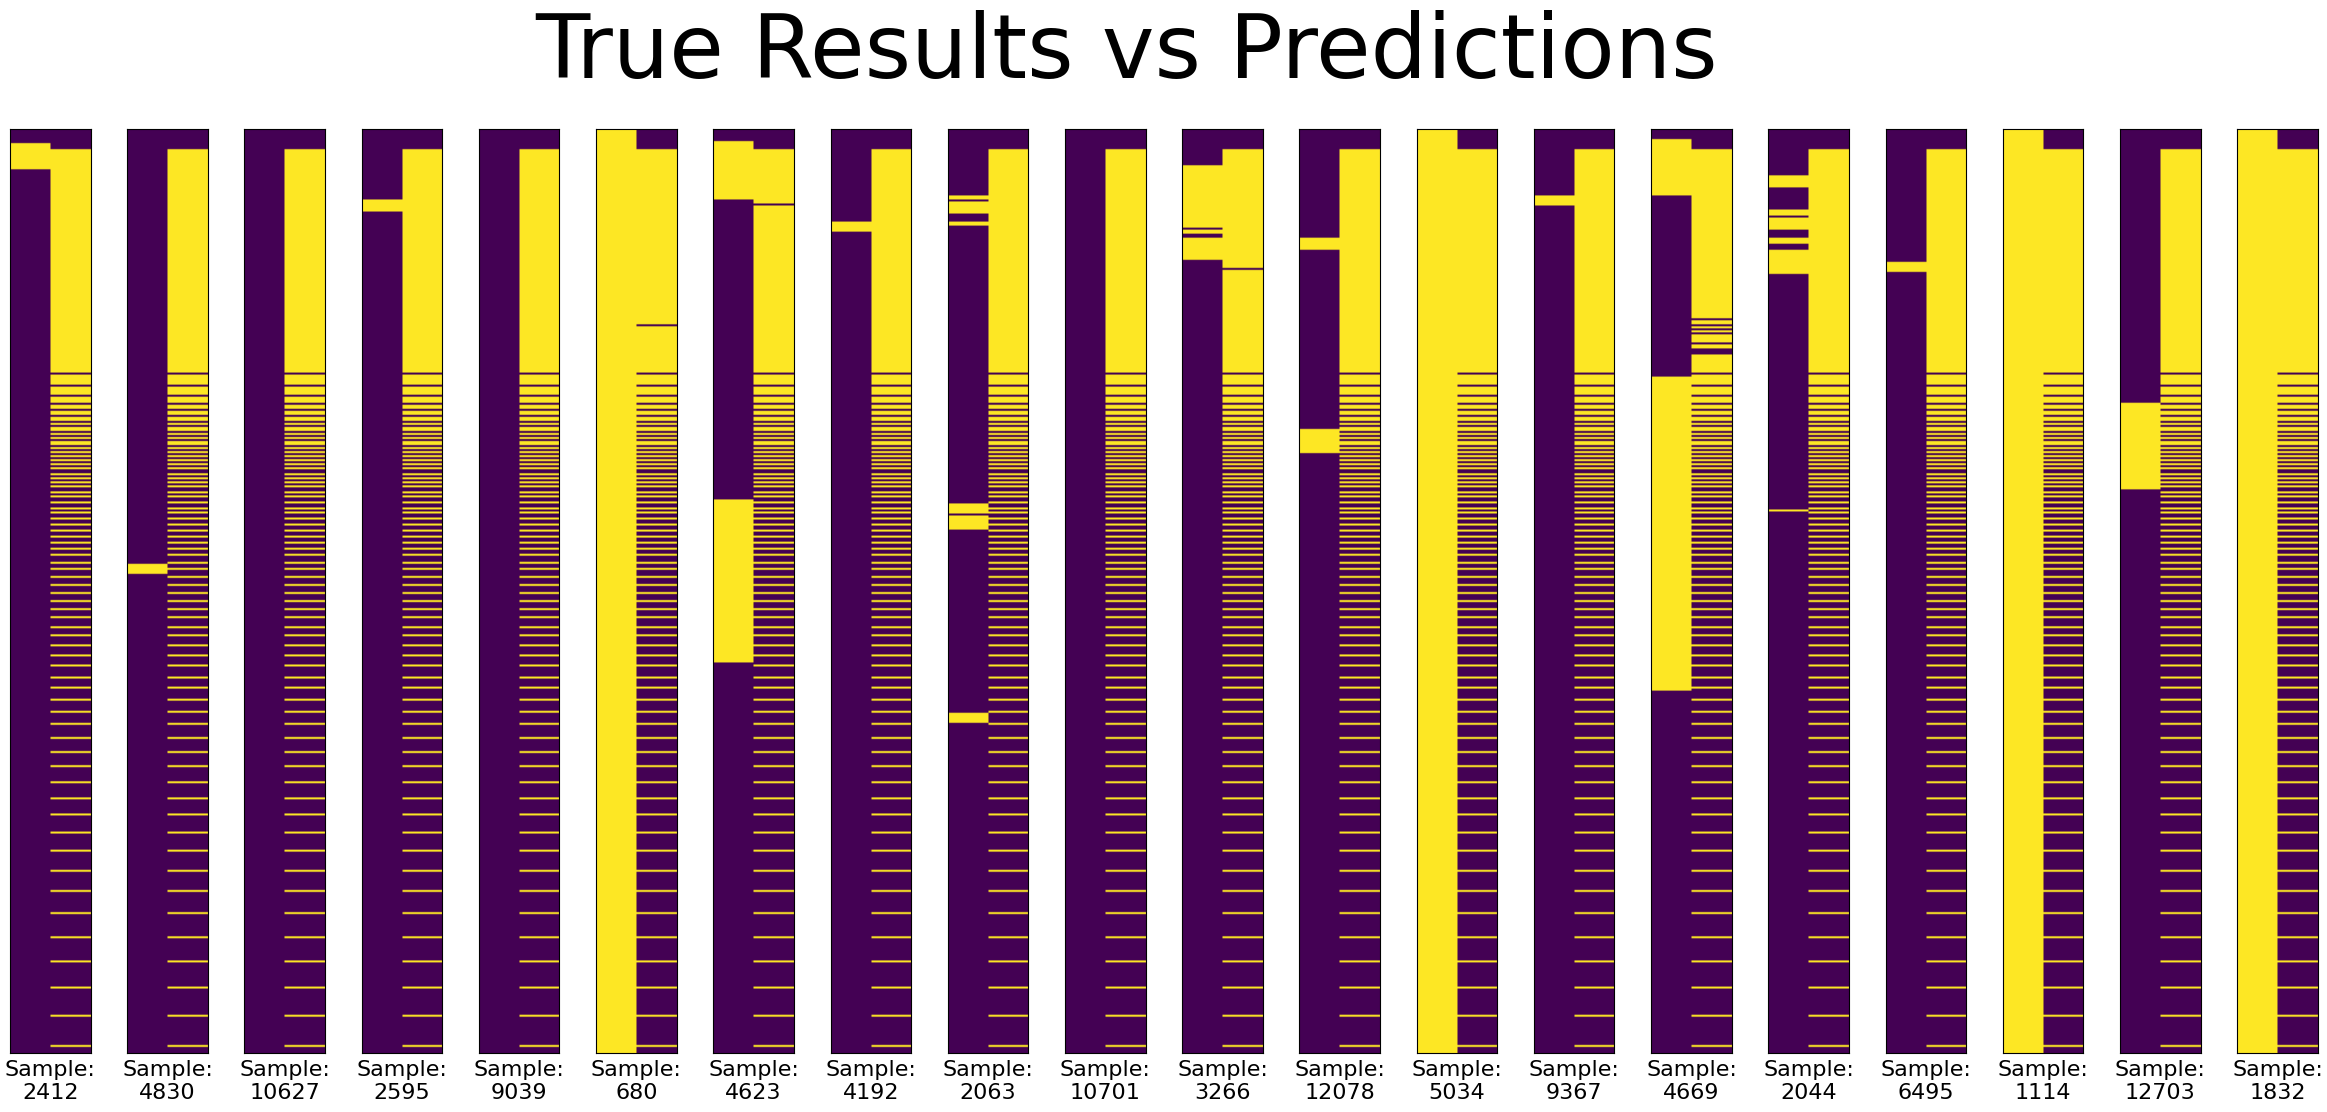

In [41]:
LABELS_PATH = Path('/gws/nopw/j04/iecdt/JERMIT_the_frog/')

labels = pd.read_csv(LABELS_PATH / 'hydrometeors_time_aligned_classes.csv', index_col=0)
y_pred = np.load(LABELS_PATH / 'stereo_preds.npy')

samples = []

fig, ax = plt.subplots(1, 20, figsize=(30, 12))
for axs in ax.flatten():
    axs.set_xticks([])
    axs.set_yticks([])

for i in range(20):
    n = np.random.randint(0, 13760)
    y_true = labels.iloc[:, n].values
    y_true = np.expand_dims(y_true, axis=1)  # Add an extra dimension to y_true

    result = np.concatenate((y_true, np.expand_dims(y_pred[:, n], axis=1)), axis=1)  # Add an extra dimension to y_pred[:, i]

    ax[i].imshow(np.repeat(result, 20, axis=1), cmap='viridis')
    samples.append(n)

for i, axs in enumerate(ax):
    axs.set_xlabel(f'Sample:\n{samples[i]}', fontsize=16)

fig.suptitle("True Results vs Predictions", fontsize=64)

In [16]:
img_A, img_B = get_imgs(labels.columns[0])


In [21]:
labels.columns[0]


'1691388010'

([], [])

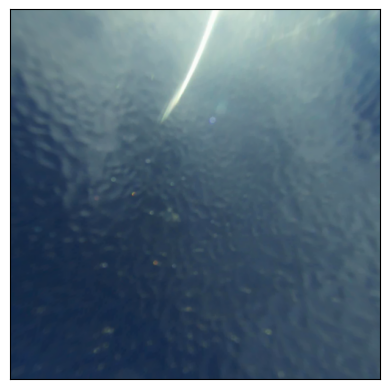

In [24]:
plt.imshow(img_A)
plt.xticks([])
plt.yticks([])